In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import albumentations as A
import imutils

(397, 435, 3)


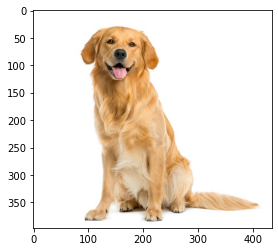

In [3]:
dog_img_BGR = cv2.imread("dog.jpg")
dog_img_RGB = cv2.cvtColor(dog_img_BGR, cv2.COLOR_BGR2RGB)
dog_w=dog_img_RGB.shape[0]
dog_h=dog_img_RGB.shape[1]
plt.imshow(dog_img_RGB)
print(dog_img_RGB.shape)

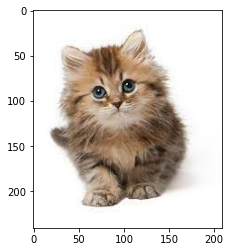

In [4]:
cat_img_BGR = cv2.imread("cat.jpg")
cat_img_RGB = cv2.cvtColor(cat_img_BGR, cv2.COLOR_BGR2RGB)
cat_w=cat_img_RGB.shape[0]
cat_h=cat_img_RGB.shape[1]
plt.imshow(cat_img_RGB)


(183, 275, 3)


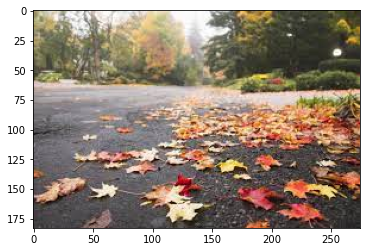

In [5]:
background_img_BGR = cv2.imread("background_img.jpg")
background_img_RGB = cv2.cvtColor(background_img_BGR, cv2.COLOR_BGR2RGB)
background_w=background_img_RGB.shape[0]
background_h=background_img_RGB.shape[1]
print(background_img_RGB.shape)
plt.imshow(background_img_RGB)

In [6]:
lower_white = np.array([255,255,255])  
upper_white = np.array([255,255,255])

(600, 600)


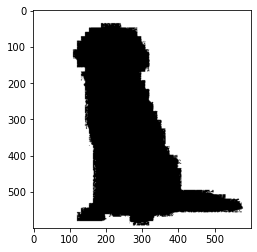

In [7]:
resized_dog_image = cv2.resize(dog_img_RGB, (600,600))
resized_background_image = cv2.resize(background_img_RGB, (600,600))
mask = cv2.inRange(resized_dog_image, lower_white, upper_white)
plt.imshow(mask, cmap='gray')
print(mask.shape)
mask_dog=mask.copy()

(600, 600, 3)

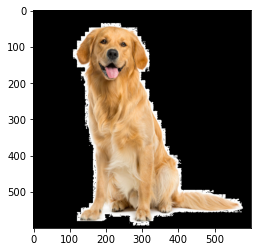

In [8]:
masked_image = np.copy(resized_dog_image)
masked_image[mask != 0] = [0, 0, 0]
plt.imshow(masked_image)
masked_image.shape

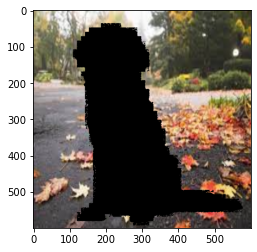

In [9]:
resized_background_image[mask == 0] = [0,0,0]
plt.imshow(resized_background_image)


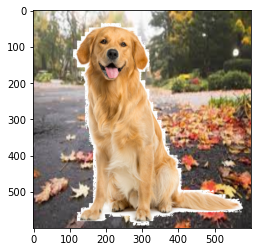

In [10]:
complete_image = masked_image + resized_background_image
plt.imshow(complete_image)

In [11]:
def get_img_and_mask(img_path, mask_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_b = mask[:,:,0] == 0 # This is boolean mask
    mask = mask_b.astype(np.uint8) # This is binary mask    
    return img, mask


Shape of the image of the object: (962, 847, 3)
Shape of the binary mask: (962, 847)


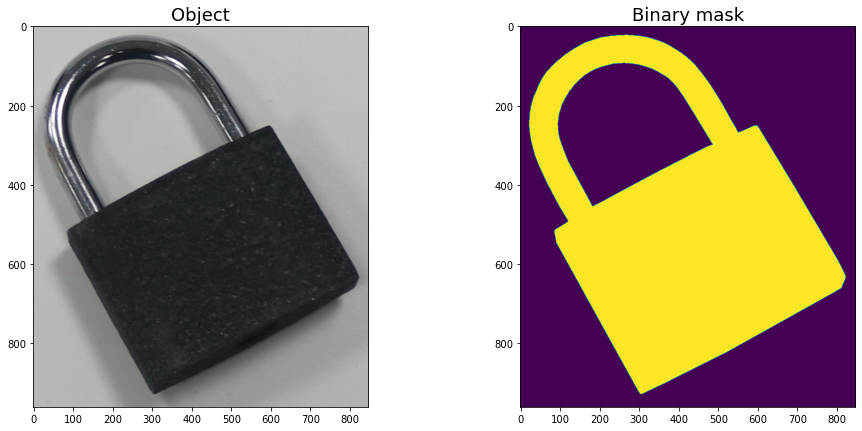

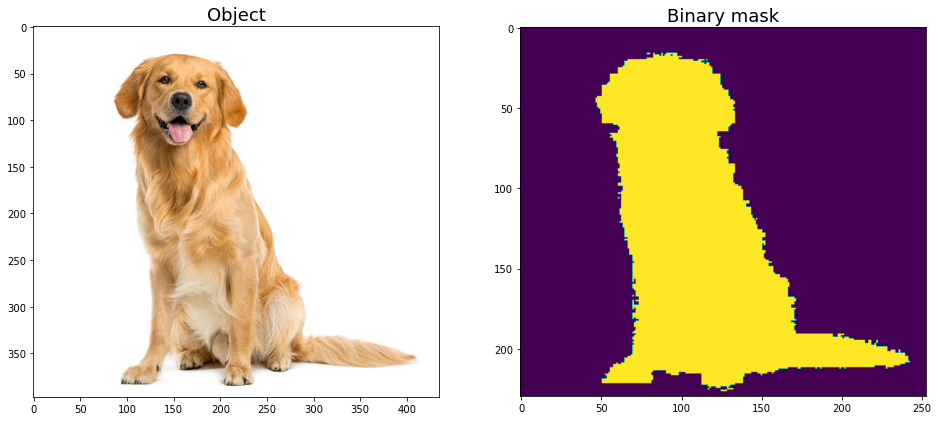

In [12]:
img_path = "1_lock.png"
mask_path = "1_masked.png"

img, mask = get_img_and_mask(img_path, mask_path)

print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18);

img_dog_path = "dog.jpg"
mask_dog_path = "masked_dog_img.jpg"
img_dog, mask_dog1 = get_img_and_mask(img_dog_path, mask_dog_path)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_dog)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask_dog1)
ax[1].set_title('Binary mask', fontsize=18);

In [13]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])

Shape of the image of the transformed object: (319, 363, 3)
Shape of the transformed binary mask: (319, 363)




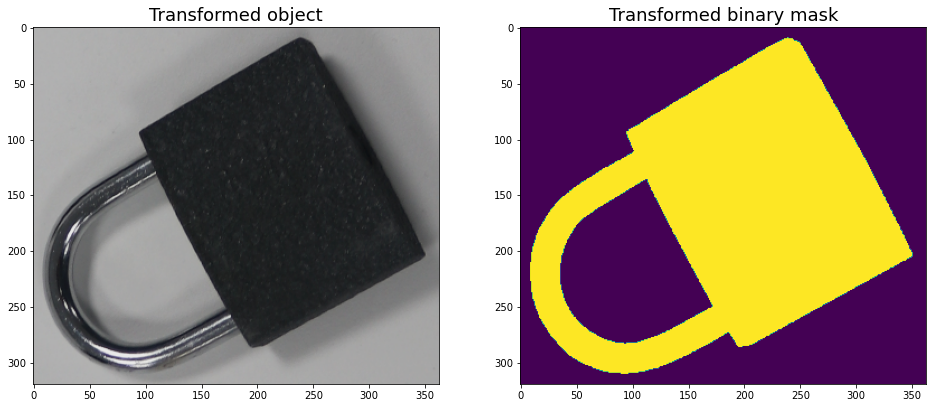

In [16]:
# Let's look how image and binary mask of a random object can be transformed
# with help of resize_transform_obj() function

img_path = "1_lock.png"
mask_path = "1_masked.png"

img, mask = get_img_and_mask(img_path, mask_path)

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     longest_min=300,
                                     longest_max=400,
                                     transforms=transforms_obj)

print("Shape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", mask_t.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18);

In [17]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (183, 275, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1277, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1080, 1920, 3)


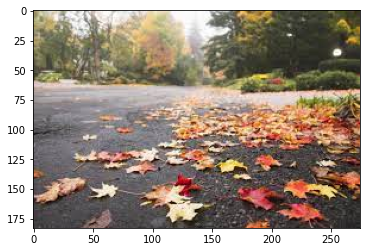

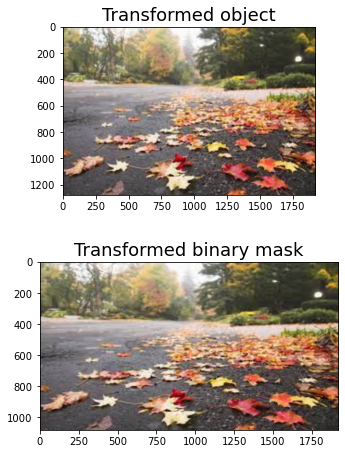

In [18]:
# Let's look how a random background image can be resized with resize_img() function

img_bg_path = "background_img.jpg"
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
plt.imshow(img_bg)
#resize_img_bg = cv2.resize(img_bg,(1920,1080))
img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)
fig, ax = plt.subplots(2, 1, figsize=(16, 7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Transformed binary mask', fontsize=18);

In [19]:
def add_obj_new(img_comp, mask_comp,img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    keypoints_comp - composition of keypoints
    img - image of object
    mask - mask of object
    keypoints - keypoints of object
    x, y - coordinates where left top corner of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp + keypoints_comp as a list
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]    
    h, w = img.shape[0], img.shape[1]   
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    img_comp[y:y+h, x:x+w, :] = img_comp[y:y+h, x:x+w, :] * ~mask_rgb_b + (img * mask_rgb_b)
    mask_comp[y:y+h, x:x+w] = mask_comp[y:y+h, x:x+w] * ~mask_b + (idx * mask_b)
    mask_added = mask[0:h, 0:w]
    return img_comp, mask_comp, mask_added

In [20]:
img_dog = cv2.resize(img_dog,(962,847))
mask_dog1 = cv2.resize(mask_dog1,(962,847))

In [21]:
resized_background_image = cv2.resize(background_img_RGB, (1900,1420))
h, w = resized_background_image.shape[0], resized_background_image.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)
mask_comp.shape


(1420, 1900)

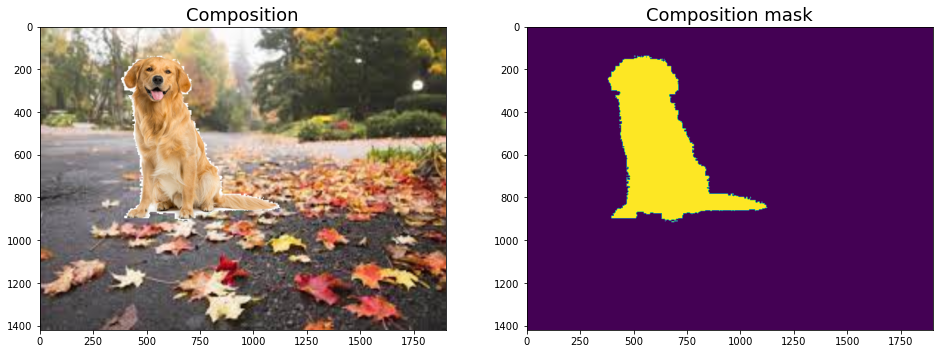

In [22]:
img_comp, mask_comp, _ = add_obj_new(resized_background_image, mask_comp,img_dog, mask_dog1, x=200, y=80, idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

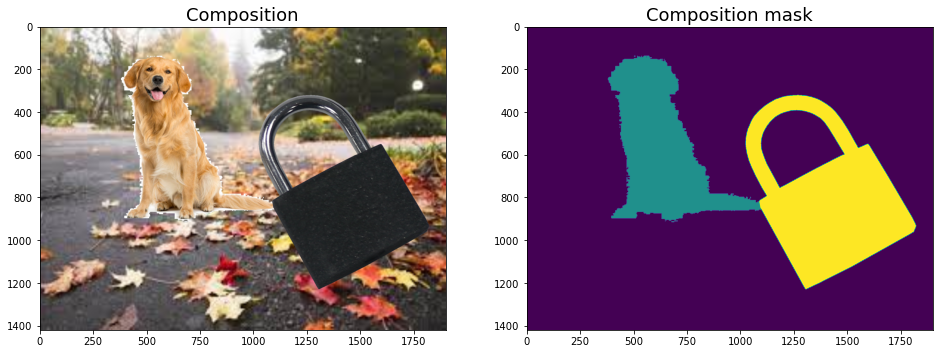

In [23]:
img_dog = cv2.resize(img_dog,(962,847))
mask_dog1 = cv2.resize(mask_dog1,(962,847))
img_comp, mask_comp, _ = add_obj_new(img_comp, mask_comp, img, mask, x=1000, y=300, idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

In [27]:
original = cv2.imread("first.png")
new = cv2.imread("second_1.png")
#resize the images to make them smaller. Bigger image may take a significantly
#more computing power and time
original = imutils.resize(original, height = 600)
new = imutils.resize(new, height = 600)


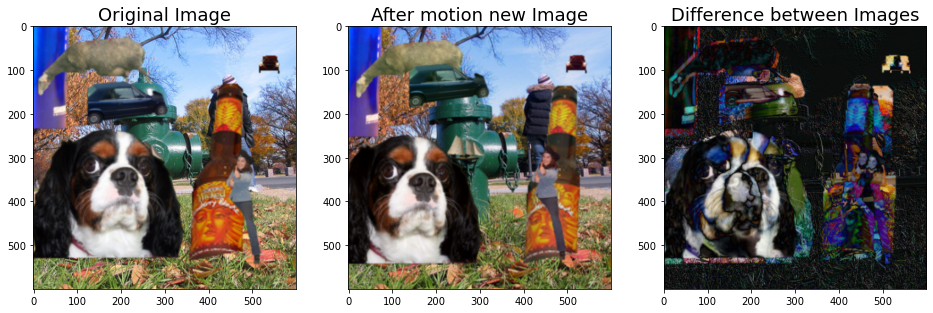

In [28]:
original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)
new =cv2.cvtColor(new,cv2.COLOR_BGR2RGB)
diff = cv2.absdiff(original, new)
diff =cv2.cvtColor(diff,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[0].imshow(original)
ax[0].set_title('Original Image', fontsize=18)
ax[1].imshow(new)
ax[1].set_title('After motion new Image', fontsize=18);
ax[2].imshow(diff)
ax[2].set_title('Difference between Images', fontsize=18);


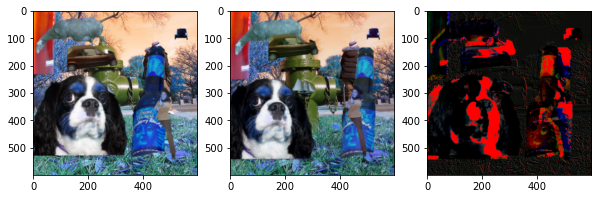

In [29]:
difference = cv2.subtract(original, new)

# color the mask red
Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)

original = cv2.cvtColor(original,cv2.COLOR_BGR2RGB)
new =cv2.cvtColor(new,cv2.COLOR_BGR2RGB)
diff = cv2.cvtColor(difference,cv2.COLOR_BGR2RGB)
# add the red mask to the images to make the differences obvious
#original[mask != 255] = [255, 0, 0]
#new[mask != 255] = [255, 0, 0]
difference[mask != 255] = [255, 0, 0]
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 2
columns = 3
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(original)
fig.add_subplot(rows, columns, 2)
plt.imshow(new)
fig.add_subplot(rows, columns, 3)
plt.imshow(difference)


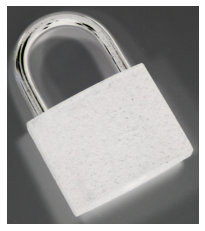

In [30]:
#Invert Image
transform = A.InvertImg(p=1.0)
augmented_image = transform(image=img)['image']
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(augmented_image)

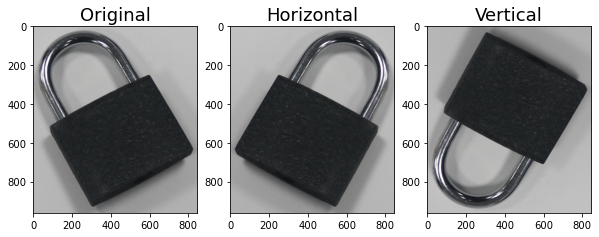

In [31]:
#HorizontalFlip
transform = A.HorizontalFlip(p=0.5)
augmented_image_h = transform(image=img)['image']

#VerticalFlip
transform = A.VerticalFlip(p=1)
augmented_image_v = transform(image=img)['image']
fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].imshow(img)
ax[0].set_title('Original', fontsize=18)
ax[1].imshow(augmented_image_h)
ax[1].set_title('Horizontal', fontsize=18);
ax[2].imshow(augmented_image_v)
ax[2].set_title('Vertical', fontsize=18);


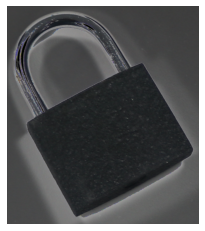

In [32]:
#Image Solarize
transform = A.Solarize(threshold=100,  p=1.0)
augmented_image = transform(image=img)['image']
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(augmented_image)